# Log Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. Load JSON logs

In [2]:
df = pd.read_json('synthetic_logs.json', lines=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])
print(df.head())
print(df.columns)

            host   uid username          ip                 timestamp   pid  \
0     beta.cloud   923      eve  10.0.25.10 2025-08-01 10:20:19+00:00  3449   
1  epsilon.local  8236      eve  10.0.41.22 2025-08-01 23:24:00+00:00  6585   
2  epsilon.local  2301      eve  10.0.31.28 2025-08-01 13:15:44+00:00  3714   
3       delta.io  9848      eve   10.0.39.8 2025-08-01 12:23:55+00:00  6108   
4       delta.io  8722     root  10.0.39.48 2025-08-01 02:19:13+00:00  6719   

   ppid process_name  
0  2603          scp  
1  2984      python3  
2  2839          ssh  
3  7485          ssh  
4  3582      python3  
Index(['host', 'uid', 'username', 'ip', 'timestamp', 'pid', 'ppid',
       'process_name'],
      dtype='object')


### 2. Event count per day

Event counts per day:
date
2025-08-01    500
2025-08-02    500
2025-08-03    500
2025-08-04    200
2025-08-05    500
2025-08-06    500
2025-08-07    500
2025-08-08    800
2025-08-09    500
2025-08-10    500
2025-08-11    500
2025-08-12    500
2025-08-13    500
2025-08-14    500
2025-08-15    500
dtype: int64


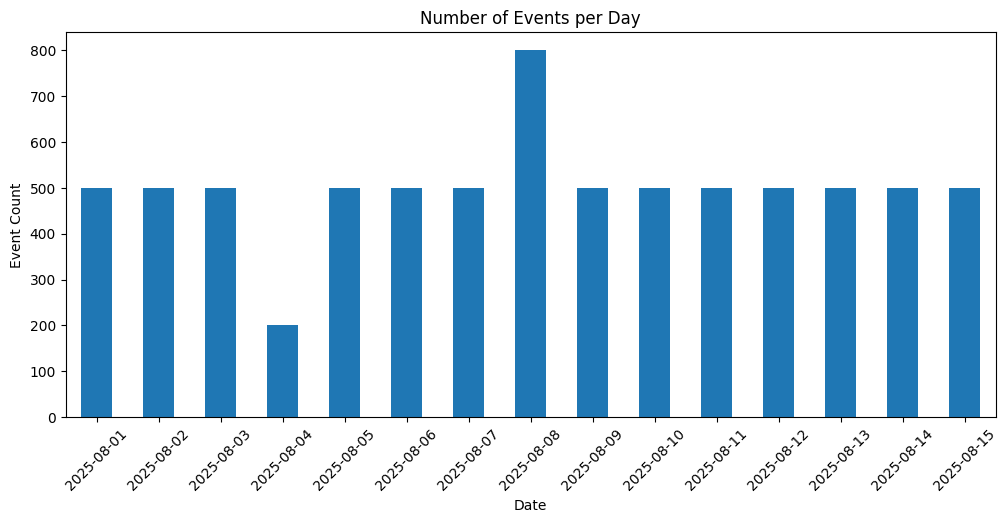

Anomalous days:
date
2025-08-04    200
2025-08-08    800
dtype: int64


In [3]:
df["date"] = df["timestamp"].dt.date
events_per_day = df.groupby("date").size()
print("Event counts per day:")
print(events_per_day)

plt.figure(figsize=(12, 5))
events_per_day.plot(kind='bar')
plt.title("Number of Events per Day")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.show()

# Mean and standard deviation
mean_events = events_per_day.mean()
std_events = events_per_day.std()

# Anomalous days (events < mean - 2 * std)
anomalies = events_per_day[(events_per_day < mean_events - 2 * std_events) | 
                           (events_per_day > mean_events + 2 * std_events)]
print("Anomalous days:")
print(anomalies)

### 3. IP accessing most hosts

In [4]:
ip_hosts = df.groupby("ip")["host"].nunique().sort_values(ascending=False)
print("Top 10 IPs by number of unique hosts accessed:")
print(ip_hosts.head(10))

top_ip = ip_hosts.idxmax()
top_ip_count = ip_hosts.max()
print(f"IP accessing the most hosts: {top_ip} ({top_ip_count} hosts)")

Top 10 IPs by number of unique hosts accessed:
ip
10.99.99.99    8
10.0.26.12     7
10.0.33.7      7
10.0.25.12     7
10.0.21.10     7
10.0.31.19     6
10.0.30.40     6
10.0.10.15     6
10.0.30.42     6
10.0.49.2      6
Name: host, dtype: int64
IP accessing the most hosts: 10.99.99.99 (8 hosts)


### 4. Suspicious users

In [5]:
# Top active users by event count
user_activity = df["username"].value_counts().head(10)
print("Top 10 most active users:")
print(user_activity)

# Users with multiple IPs
user_ips = df.groupby("username")["ip"].nunique().sort_values(ascending=False).head(10)
print("Top 10 users with most IPs:")
print(user_ips)

# Suspicious users (top active AND with multiple IPs)
top_users_activity = set(user_activity.index)
top_users_ips = set(user_ips.index)

suspicious_users = top_users_activity.intersection(top_users_ips)
print("Suspicious users:")
print(", ".join(suspicious_users))

Top 10 most active users:
username
root       699
eve        671
trent      670
bob        543
lisa       527
dave       510
mike       504
john       504
charlie    496
mallory    485
Name: count, dtype: int64
Top 10 users with most IPs:
username
root       599
eve        583
trent      581
bob        487
lisa       462
dave       458
mike       455
john       454
mallory    435
charlie    433
Name: ip, dtype: int64
Suspicious users:
eve, charlie, lisa, root, dave, mike, bob, john, mallory, trent


### 5. Process chains (PID -> PPID)

In [6]:
proc_chains = df.dropna(subset=["pid", "ppid"])
chains = proc_chains.groupby("host")[["pid", "ppid", "process_name"]]

for host, group in chains:
    print(f"\nHost: {host}")
    for _, row in group.iterrows():
        print(f"PPID={row['ppid']} → PID={row['pid']} ({row['process_name']})")

hosts_with_chains = proc_chains['host'].unique()
print("Process chains detected on hosts:")
print(", ".join(hosts_with_chains))


Host: alpha.net
PPID=1967 → PID=8090 (sshfs)
PPID=7837 → PID=4100 (rsync)
PPID=4839 → PID=8897 (python3)
PPID=6824 → PID=8177 (ftp)
PPID=7942 → PID=7108 (vim)
PPID=3686 → PID=3493 (vim)
PPID=7763 → PID=4537 (rsync)
PPID=5281 → PID=6812 (scp)
PPID=3994 → PID=8579 (rsync)
PPID=4720 → PID=6548 (ssh)
PPID=2651 → PID=4231 (rsync)
PPID=3167 → PID=1619 (ping)
PPID=2781 → PID=3764 (ftp)
PPID=1880 → PID=8391 (ping)
PPID=2802 → PID=1053 (curl)
PPID=7001 → PID=2159 (rsync)
PPID=6340 → PID=9674 (curl)
PPID=6897 → PID=6265 (vim)
PPID=7062 → PID=5595 (vim)
PPID=8220 → PID=7584 (ftp)
PPID=7474 → PID=3559 (vim)
PPID=7612 → PID=4414 (rsync)
PPID=8311 → PID=5324 (ping)
PPID=9290 → PID=5051 (scp)
PPID=3269 → PID=9246 (ftp)
PPID=4671 → PID=8236 (sshfs)
PPID=5896 → PID=5623 (curl)
PPID=7941 → PID=6259 (rsync)
PPID=9605 → PID=7815 (ftp)
PPID=5302 → PID=9709 (rsync)
PPID=1224 → PID=1340 (ping)
PPID=1209 → PID=9408 (curl)
PPID=8870 → PID=6081 (scp)
PPID=8552 → PID=2981 (rsync)
PPID=6437 → PID=1827 (python3)
